In [1]:
import numpy as np
from math import log, pi
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.validation import check_array, check_X_y, check_is_fitted

class RBFKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    """
    k-NN classifier with RBF (isotropic multivariate normal) weighting.

    Parameters
    ----------
    k : int, default=sqrt(n_training_samples)
        Number of neighbors to consider.
    h : float, default=\frac{e^{-1}}{mean(dist_training_samples)^{-2}+mean(dist_training_samples)^{-1/2}}
        Radius (std. deviation) of the isotropic RBF (covariance = h^2 * I).
    """

    def default_k(self, n_samples):
        return int(np.floor(np.sqrt(n_samples)))

    def default_h(self, n_samples, X):
        # compute average pairwise distance (inefficient for large n_samples)
        dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
        mean_dist = np.sum(dists) / (n_samples * (n_samples - 1))  # exclude self-distances
        return np.exp(-1) / (mean_dist ** -2 + mean_dist ** -0.5)

    def __init__(self, k: int | None = None, h: float | None = None):
        self.k_ = k
        self.h_ = h

    def pre_fit(self, X, y):
        X, y = check_X_y(X, y)
        return X, y

    def fit(self, X, y):
        X, y = self.pre_fit(X, y)

        n_samples, n_features = X.shape

        # default k: sqrt(n_samples)
        if self.k_ is None:
            self.k_ = self.default_k(n_samples)

        # default h: based on average pairwise distance in training set
        if self.h_ is None:
            self.h_ = self.default_h(n_samples, X)


        if self.h_ <= 0:
            raise ValueError("h must be > 0 (standard deviation of RBF).")
        
        k_eff = min(max(1, self.k_), n_samples)

        # store data
        self.X_ = X.copy()
        self.y_ = np.asarray(y).copy()
        self.n_features_in_ = n_features

        # classes and integer-encoded labels
        self.classes_, inv = np.unique(self.y_, return_inverse=True)
        self._y_encoded = inv  # length n_samples, values in [0, n_classes-1]
        self.n_classes_ = self.classes_.shape[0]

        # nearest-neighbor structure
        self._k_eff = k_eff
        self._nn = NearestNeighbors(n_neighbors=self._k_eff)
        self._nn.fit(self.X_)

        return self

    def _rbf_logpdf_const(self):
        # constant term of isotropic multivariate normal log-pdf

        if self.k_ is None or self.h_ is None:
            raise ValueError("k and h must be set (not None) before calling this method.")

        d = self.n_features_in_
        return -0.5 * d * (np.log(2 * pi) + np.log(self.h_ * self.h_))
    
    def kernel(self, X):
        check_is_fitted(self, attributes=['X_', 'y_', '_nn', 'k_', 'h_'])
        X = check_array(X, dtype=float)
        n_test = X.shape[0]

        if self.k_ is None or self.h_ is None:
            raise ValueError("k and h must be set (not None) before calling this method.")

        # get k nearest neighbors (distances returned in Euclidean norm)
        dists, idxs = self._nn.kneighbors(X, n_neighbors=self._k_eff, return_distance=True)
        # dists shape (n_test, k), idxs same shape
        dists_sq = dists ** 2  # squared euclidean distances

        # compute log-weights for each neighbor: logpdf of N(mu=neighbor, cov=h^2 I)
        const = self._rbf_logpdf_const()
        logw = const - 0.5 * (dists_sq / (self.h_ * self.h_))  # shape (n_test, k)

        # numerical stabilization: subtract max per row before exponentiation
        max_logw = np.max(logw, axis=1, keepdims=True)
        stable_w = np.exp(logw - max_logw)  # now safe to exponentiate

        # accumulate weighted votes per class
        probs = np.zeros((n_test, self.n_classes_), dtype=float)
        neighbor_classes = self._y_encoded[idxs]  # shape (n_test, k)

        # vectorized accumulation per sample using bincount (loop over tests)
        for i in range(n_test):
            w = stable_w[i]
            cls_idx = neighbor_classes[i]
            # sum weights for each class among neighbors
            counts = np.bincount(cls_idx, weights=w, minlength=self.n_classes_)
            probs[i, :] = counts

        return probs, neighbor_classes

    def predict_proba(self, X):
        probs, neighbor_classes = self.kernel(X)

        # normalize to probabilities
        row_sums = probs.sum(axis=1, keepdims=True)
        # if any row sums are zero (unlikely due to stabilization), assign uniform over neighbor classes
        zero_mask = (row_sums.squeeze() == 0)
        if zero_mask.any():
            for i in np.nonzero(zero_mask)[0]:
                present = np.unique(neighbor_classes[i])
                probs[i, :] = 0.0
                probs[i, present] = 1.0 / present.size
            row_sums = probs.sum(axis=1, keepdims=True)

        probs /= row_sums
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def likelihood_space(self):
        """
        Returns the training data projection in the likelihood space.
        """
        likelihoods, _ = self.kernel(self.X_)

        # Normalize by the max likelihood to ensure the domain is [0, 1]
        likelihoods /= np.max(likelihoods)

        return likelihoods


In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0) #type: ignore
clf_ref = RBFKNeighborsClassifier()
clf_ref.fit(X_train, y_train)
print("Accuracy:", clf_ref.score(X_test, y_test))
probs = clf_ref.predict_proba(X_test[:5])
print("Probs for first 5 test samples:\n", probs)


Accuracy: 0.9736842105263158
Probs for first 5 test samples:
 [[0.         0.06962706 0.93037294]
 [0.         1.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [1.         0.         0.        ]]


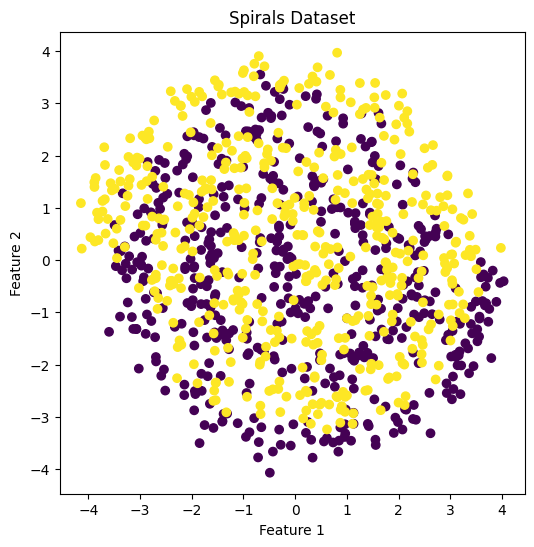

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def make_spirals(n_samples=100, turns=3, noise=0.1, dr=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples_per_class = n_samples // 2
    theta = np.sqrt(np.random.rand(n_samples_per_class)) * turns * 2 * np.pi  # angle
    r_a = dr * theta + noise * np.random.randn(n_samples_per_class)  # radius
    x_a = r_a * np.cos(theta)
    y_a = r_a * np.sin(theta)
    class_a = np.zeros(n_samples_per_class, dtype=int)
    r_b = -dr * theta + noise * np.random.randn(n_samples_per_class)  # radius
    x_b = r_b * np.cos(theta)
    y_b = r_b * np.sin(theta)
    class_b = np.ones(n_samples_per_class, dtype=int)
    return np.vstack([np.column_stack([x_a, y_a]), np.column_stack([x_b, y_b])]), np.hstack([class_a, class_b])

X, y = make_spirals(n_samples=1000, noise=0.3, dr=0.2, random_state=0)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Spirals Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Test accuracy: 0.6152  (k=18, h=0.3504159898355551)


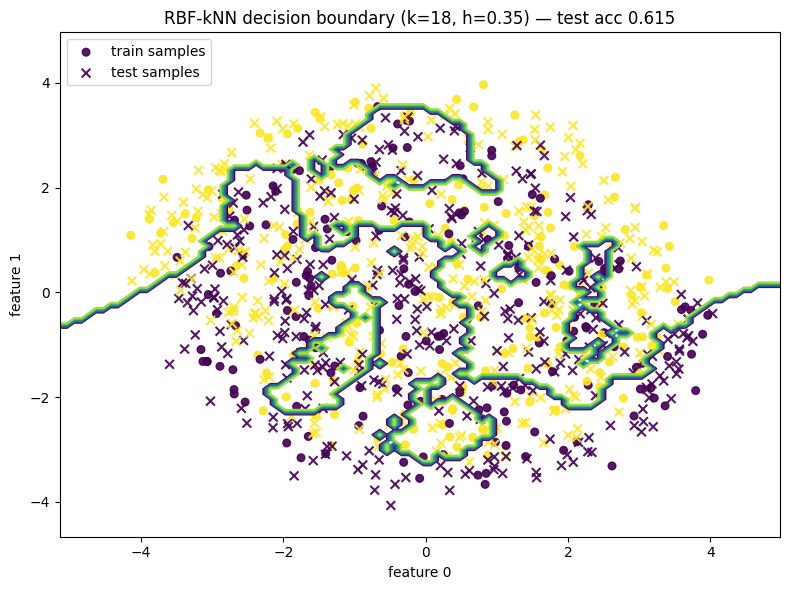

In [4]:

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# --- Configuration ---
k_ = None         # number of neighbors - use default sqrt(n_samples)
h_ = None         # RBF radius (std. dev.) - use default based on training set
random_state = 0
n_samples = 1000

# Choose toy dataset
TOY_DATASET = 'spirals'  # options: 'moons', 'circles', 'spirals'

if TOY_DATASET == 'moons':
    def make_toy(n_samples, noise=0.33):
        return make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
elif TOY_DATASET == 'circles':
    def make_toy(n_samples, noise=0.2):
        return make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=random_state)
elif TOY_DATASET == 'spirals':
    def make_toy(n_samples, noise=0.3, dr=0.2):
        return make_spirals(n_samples=n_samples, noise=noise, dr=dr, random_state=random_state)
else:
    raise ValueError("Invalid TOY_DATASET. Choose 'moons', 'circles', 'spirals'.")

# --- Prepare data ---
X, y = make_toy(n_samples)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.66, stratify=y, random_state=random_state
)

# --- Build pipeline: scaling + classifier ---
clf_ref = RBFKNeighborsClassifier(k=k_, h=h_)  # use your implementation
pipe = make_pipeline(StandardScaler(), clf_ref)

# --- Fit and evaluate ---
pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)
print(f"Test accuracy: {acc:.4f}  (k={pipe.named_steps['rbfkneighborsclassifier'].k_}, h={pipe.named_steps['rbfkneighborsclassifier'].h_})")

# --- Decision boundary visualization ---
fig, ax = plt.subplots(figsize=(8, 6))

# DecisionBoundaryDisplay will plot the decision function
DecisionBoundaryDisplay.from_estimator(
    pipe,
    X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax, #type: ignore
)

# Overlay training points (color-coded by class)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.9)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)

ax.set_title(f"RBF-kNN decision boundary (k={pipe.named_steps['rbfkneighborsclassifier'].k_}, h={pipe.named_steps['rbfkneighborsclassifier'].h_:.2f}) — test acc {acc:.3f}")
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [5]:
def gabriel_graph(X):
    """
    Compute the Gabriel graph matrix for a set of points.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input points
        
    Returns
    -------
    adjacency_matrix : ndarray of shape (n_samples, n_samples)
        Binary adjacency matrix where 1 indicates an edge and 0 indicates no edge
    """
    X = np.asarray(X)
    n_points = X.shape[0]
    adjacency_matrix = np.zeros((n_points, n_points), dtype=int)
    
    for i in range(n_points):
        for j in range(i + 1, n_points):
            # Midpoint of edge (i, j)
            midpoint = (X[i] + X[j]) / 2
            # Radius of the circle (half the distance between i and j)
            radius = np.linalg.norm(X[i] - X[j]) / 2
            
            # Check if any other point lies inside the circle
            is_gabriel_edge = True
            for k in range(n_points):
                if k != i and k != j:
                    dist_to_midpoint = np.linalg.norm(X[k] - midpoint)
                    if dist_to_midpoint < radius:
                        is_gabriel_edge = False
                        break
            
            if is_gabriel_edge:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    
    return adjacency_matrix

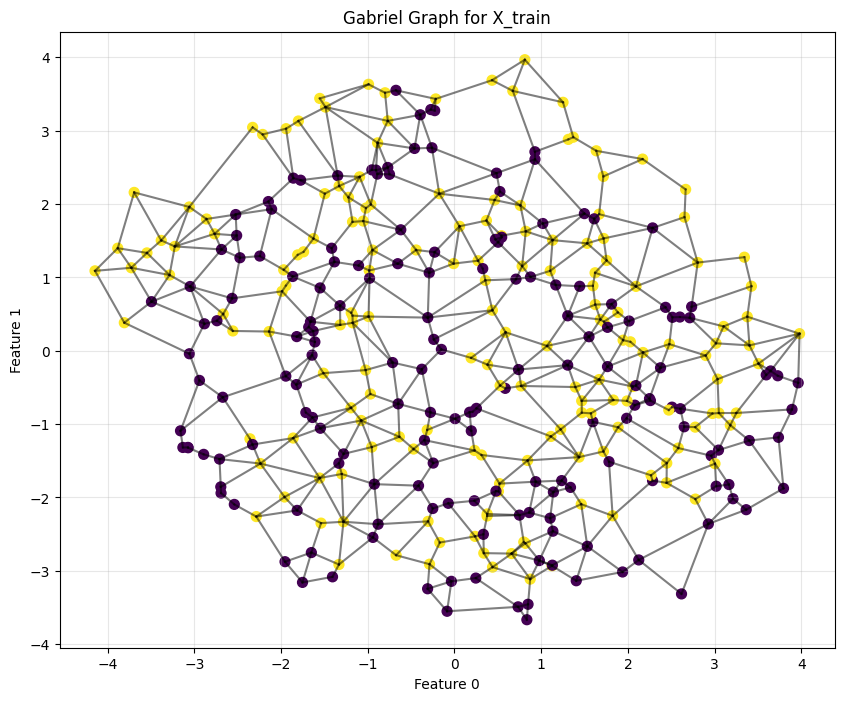

Number of points: 340
Number of Gabriel graph edges: 648
Maximum possible edges: 57630


In [6]:
# Compute Gabriel graph for X_train
gabriel_adj = gabriel_graph(X_train)

# Create visualization
plt.figure(figsize=(10, 8))

# Plot the points colored by class
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, label='Points', cmap='viridis')

# Draw edges for Gabriel graph
n_points = X_train.shape[0]
for i in range(n_points):
    for j in range(i + 1, n_points):
        if gabriel_adj[i, j] == 1:
            plt.plot([X_train[i, 0], X_train[j, 0]], 
                    [X_train[i, 1], X_train[j, 1]],
                    'k', alpha=0.5)

plt.title('Gabriel Graph for X_train')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
n_edges = np.sum(gabriel_adj) // 2  # divide by 2 since matrix is symmetric
print(f"Number of points: {n_points}")
print(f"Number of Gabriel graph edges: {n_edges}")
print(f"Maximum possible edges: {n_points * (n_points - 1) // 2}")

In [7]:
def support_graph(gabriel_adj, y):
    """
    Return an adjacency matrix indicating Gabriel edges between points of different classes.
    
    Parameters
    ----------
    gabriel_adj : array-like of shape (n_samples, n_samples)
        Binary adjacency matrix of Gabriel graph
    y : array-like of shape (n_samples,)
        Class labels for each sample
        
    Returns
    -------
    support_graph_matrix : ndarray of shape (n_samples, n_samples)
        Binary matrix where 1 indicates a Gabriel edge between points of different classes
    """
    gabriel_adj = np.asarray(gabriel_adj)
    y = np.asarray(y)
    n_samples = gabriel_adj.shape[0]
    
    # Create matrix indicating different classes
    different_classes = (y[:, np.newaxis] != y[np.newaxis, :]).astype(int)
    
    # Element-wise multiplication: 1 only if Gabriel edge AND different classes
    support_graph_matrix = gabriel_adj * different_classes

    return support_graph_matrix

In [8]:
def support_vectors(X, y, support_graph_matrix):
    """
    Identify support vectors based on the support graph matrix.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input points
    y : array-like of shape (n_samples,)
        Class labels for each sample
    support_graph_matrix : array-like of shape (n_samples, n_samples)
        Binary adjacency matrix indicating Gabriel edges between points of different classes
        
    Returns
    -------
    support_vectors: ndarray of shape (m, n_features)
        Points that are support vectors (connected to at least one point of a different class)
    """
    support_graph_matrix = np.asarray(support_graph_matrix)
    
    # A point is a support vector if it has at least one edge in the support graph
    is_support_vector = np.any(support_graph_matrix, axis=1)

    return X[is_support_vector], y[is_support_vector]

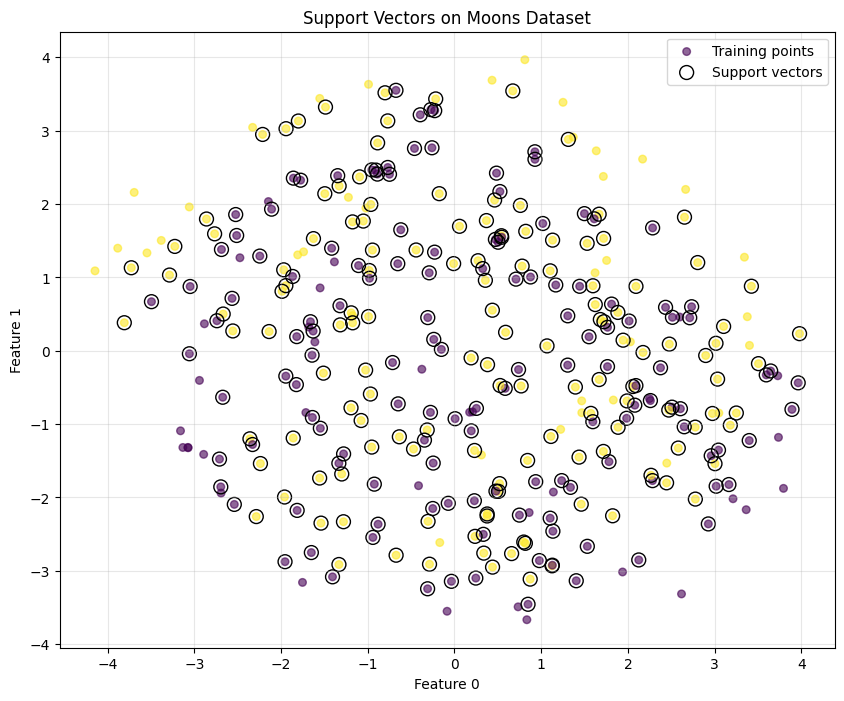

Total training points: 340
Number of support vectors: 270
Percentage of support vectors: 79.4%


In [9]:
# Compute support graph and support vectors for the training data
support_graph_mat = support_graph(gabriel_adj, y_train)
X_sup, _ = support_vectors(X_train, y_train, support_graph_mat)

# Create visualization of support vectors
plt.figure(figsize=(10, 8))

# Plot all training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, alpha=0.6, 
           label='Training points', cmap='viridis')

# Highlight support vectors
plt.scatter(X_sup[:, 0], X_sup[:, 1], 
           s=100, facecolors='none', edgecolors='black', linewidth=1,
           label='Support vectors')

plt.title('Support Vectors on Moons Dataset')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total training points: {len(X_train)}")
print(f"Number of support vectors: {len(X_sup)}")
print(f"Percentage of support vectors: {len(X_sup)/len(X_train)*100:.1f}%")

In [10]:
from scipy.spatial import cKDTree

def gabriel_approx(X):
    """
    Hyperparameter-free approximate Gabriel graph.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input points

    Returns
    -------
    adjacency_matrix : ndarray of shape (n_samples, n_samples)
        Binary adjacency matrix where 1 indicates an edge and 0 indicates no edge
    """
    X = np.asarray(X)
    n, d = X.shape
    
    if n <= 1:
        return np.zeros((n, n), dtype=int)

    # Data-driven choices for number of projections and neighbor window
    m = max(1, int(np.ceil(np.log2(n))))
    w = max(2, int(np.ceil(np.log2(n))))

    # deterministic seed derived from X
    # create a cheap hash from rounded coordinates
    flat = np.floor(X.ravel() * 1e6).astype(np.int64)
    seed = int((flat.sum() ^ (flat.prod() if flat.size<100 else flat[:100].sum())) & 0xFFFFFFFF)
    rng = np.random.RandomState(seed)

    # build KD-tree for radius queries
    tree = cKDTree(X)

    # prepare projection vectors
    vs = rng.normal(size=(m, d))
    # normalize
    vs /= np.linalg.norm(vs, axis=1, keepdims=True)

    candidates = set()
    for v in vs:
        s = X.dot(v)
        order = np.argsort(s)
        # neighbor window in 1-D ordering
        for pos, i in enumerate(order):
            lo = max(0, pos - w)
            hi = min(n - 1, pos + w)
            # enumerate neighbor indices in the ordering
            for qpos in range(lo, hi + 1):
                j = order[qpos]
                if i < j:
                    candidates.add((i, j))
                elif j < i:
                    candidates.add((j, i))

    # epsilon for numeric robustness (data-driven)
    max_abs = np.max(np.abs(X)) if X.size > 0 else 1.0
    eps = 1e-12 + np.finfo(float).eps * (max_abs + 1.0)

    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((n, n), dtype=int)
    
    # check Gabriel property for each candidate pair
    # use KD-tree radius query
    for (i, j) in candidates:
        pi = X[i]
        pj = X[j]
        mid = (pi + pj) * 0.5
        r = 0.5 * np.linalg.norm(pi - pj)
        # query for any point within radius r + tiny_eps
        idxs = tree.query_ball_point(mid, r + eps)
        # remove i and j if present
        has_other = any(k != i and k != j for k in idxs)
        if not has_other:
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1

    return adjacency_matrix

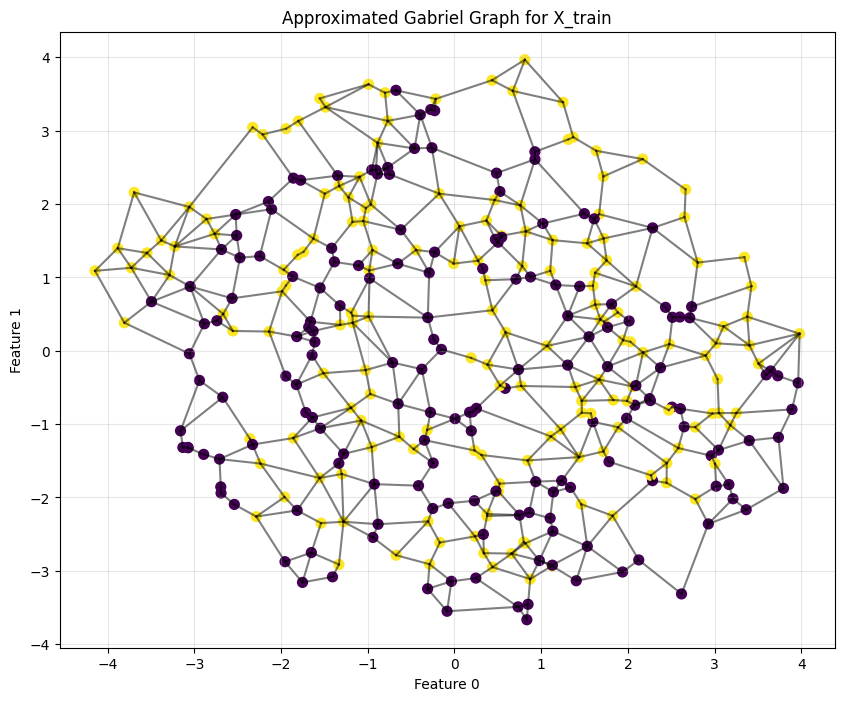

Number of points: 340
Number of approximated Gabriel graph edges: 612
Maximum possible edges: 57630


In [11]:
# Compute approximated Gabriel graph for X_train
gabriel_approx_adj = gabriel_approx(X_train)

# Create visualization
plt.figure(figsize=(10, 8))

# Plot the points colored by class
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, label='Points', cmap='viridis')

# Draw edges for approximated Gabriel graph
n_points = X_train.shape[0]
for i in range(n_points):
    for j in range(i + 1, n_points):
        if gabriel_approx_adj[i, j] == 1:
            plt.plot([X_train[i, 0], X_train[j, 0]], 
                    [X_train[i, 1], X_train[j, 1]],
                    'k', alpha=0.5)

plt.title('Approximated Gabriel Graph for X_train')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
n_edges = np.sum(gabriel_approx_adj) // 2  # divide by 2 since matrix is symmetric
print(f"Number of points: {n_points}")
print(f"Number of approximated Gabriel graph edges: {n_edges}")
print(f"Maximum possible edges: {n_points * (n_points - 1) // 2}")

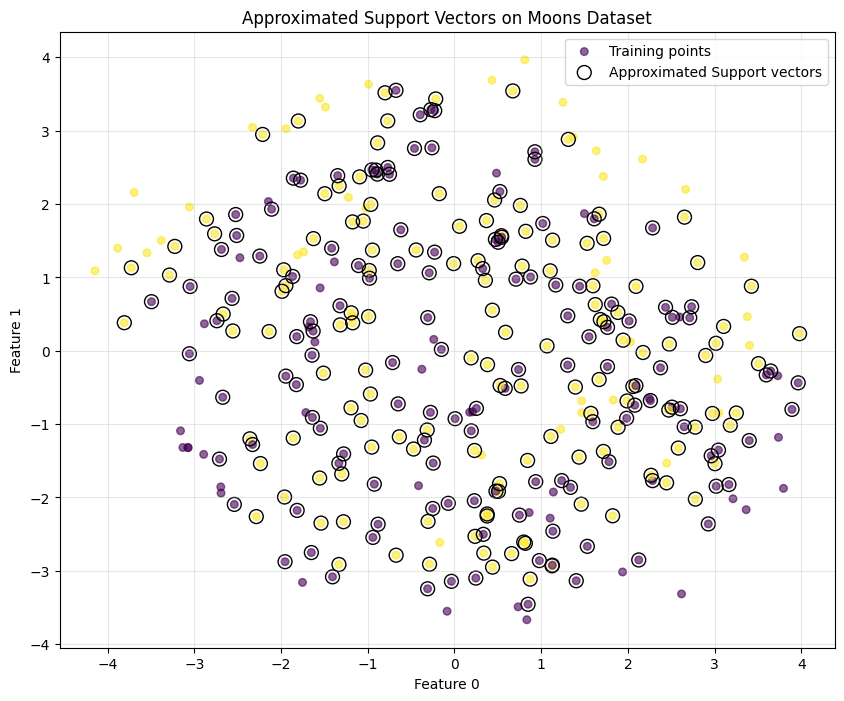

Total training points: 340
Number of approximated support vectors: 262
Percentage of approximated support vectors: 77.1%


In [12]:
# Compute support graph and support vectors for the training data
support_approx_mat = support_graph(gabriel_approx_adj, y_train)
X_sup, _ = support_vectors(X_train, y_train, support_approx_mat)

# Create visualization of support vectors
plt.figure(figsize=(10, 8))

# Plot all training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, alpha=0.6, 
           label='Training points', cmap='viridis')

# Highlight support vectors
plt.scatter(X_sup[:, 0], X_sup[:, 1], 
           s=100, facecolors='none', edgecolors='black', linewidth=1,
           label='Approximated Support vectors')

plt.title('Approximated Support Vectors on Moons Dataset')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total training points: {len(X_train)}")
print(f"Number of approximated support vectors: {len(X_sup)}")
print(f"Percentage of approximated support vectors: {len(X_sup)/len(X_train)*100:.1f}%")

In [13]:
class SVRBFKNeighborsClassifier(RBFKNeighborsClassifier):
    """
    k-NN classifier with RBF (isotropic multivariate normal) weighting,
    using only support vectors from the Gabriel graph between classes.
    """

    sv_mask: np.ndarray

    def get_support_samples(self, X, y):
        X, y = super().pre_fit(X, y)
        gabriel_adj = gabriel_approx(X)
        support_graph_mat = support_graph(gabriel_adj, y)
        X_sup, y_sup = support_vectors(X, y, support_graph_mat)

        self.sv_mask = np.any(support_graph_mat, axis=1)

        return X_sup, y_sup

    def pre_fit(self, X, y):
        return self.get_support_samples(X, y)

In [14]:
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0) #type: ignore

clf_ref = RBFKNeighborsClassifier()
clf_ref.fit(X_train, y_train)

clf_sv = SVRBFKNeighborsClassifier()
clf_sv.fit(X_train, y_train)

ref_acc = clf_ref.score(X_test, y_test)
sv_acc = clf_sv.score(X_test, y_test)

print(f"Reference k-NN accuracy: {ref_acc:.3f} (using {len(X_train)} points)")
print(f"Support-vector k-NN accuracy: {sv_acc:.3f} (using {len(clf_sv.X_)} points)")



Reference k-NN accuracy: 0.974 (using 112 points)
Support-vector k-NN accuracy: 0.632 (using 23 points)


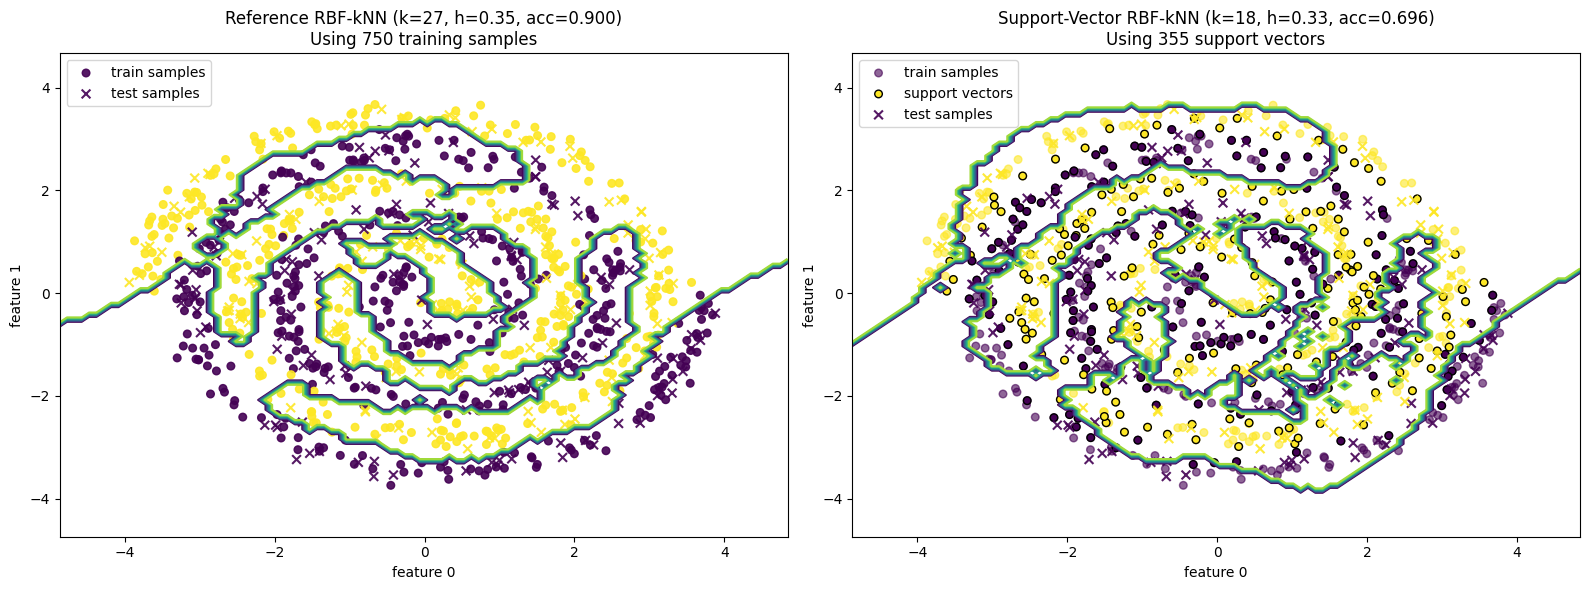

In [15]:
random_state = 0
n_samples = 1000
noise = 0.15

# --- Prepare data ---
X, y = make_toy(n_samples=n_samples, noise=noise)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=random_state
)

# --- Build reference pipeline: scaling + classifier ---
clf_ref = RBFKNeighborsClassifier()
pipe = make_pipeline(StandardScaler(), clf_ref)

# --- Fit and evaluate reference ---
pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)

# --- Build support-vector pipeline: scaling + classifier ---
clf_sv = SVRBFKNeighborsClassifier()
pipe_sv = make_pipeline(StandardScaler(), clf_sv)

# --- Fit and evaluate support-vector ---
pipe_sv.fit(X_train, y_train)
sv_acc = pipe_sv.score(X_test, y_test)

# --- Decision boundary visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Reference classifier
DecisionBoundaryDisplay.from_estimator(
    pipe,
    X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax1,
)

ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.9)
ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)
ax1.set_title(f"Reference RBF-kNN (k={pipe.named_steps['rbfkneighborsclassifier'].k_}, h={pipe.named_steps['rbfkneighborsclassifier'].h_:.2f}, acc={acc:.3f})\nUsing {len(X_train)} training samples")
ax1.set_xlabel("feature 0")
ax1.set_ylabel("feature 1")
ax1.legend(loc="upper left")

# Right plot: Support vector classifier
DecisionBoundaryDisplay.from_estimator(
    pipe_sv,
    X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax2,
)

sv_mask = pipe_sv.named_steps['svrbfkneighborsclassifier'].sv_mask

X_sup, y_sup = X_train[sv_mask], y_train[sv_mask]

ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.6)
ax2.scatter(X_sup[:, 0], X_sup[:, 1], c=y_sup, s=30, edgecolors='black', label="support vectors")
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)
ax2.set_title(f"Support-Vector RBF-kNN (k={pipe_sv.named_steps['svrbfkneighborsclassifier'].k_}, h={pipe_sv.named_steps['svrbfkneighborsclassifier'].h_:.2f}, acc={sv_acc:.3f})\nUsing {len(X_sup)} support vectors")
ax2.set_xlabel("feature 0")
ax2.set_ylabel("feature 1")
ax2.legend(loc="upper left")
plt.tight_layout()
plt.show()

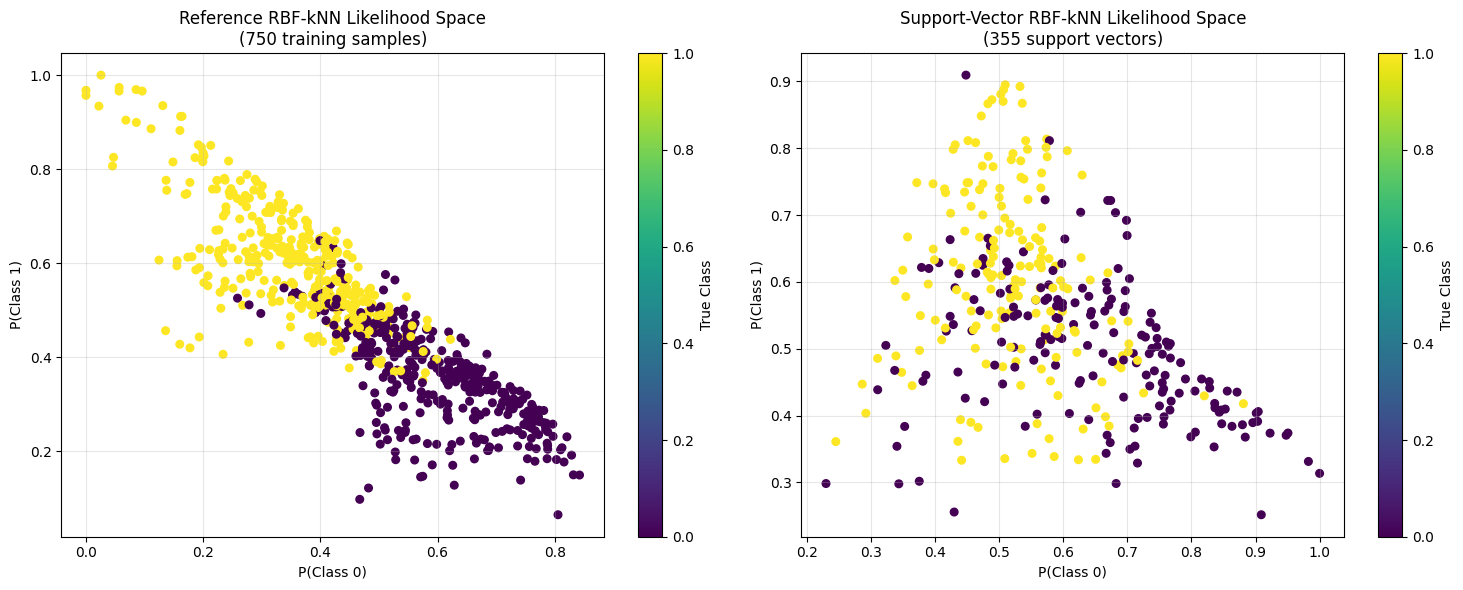

Reference model likelihood space shape: (750, 2)
Support vector model likelihood space shape: (355, 2)


In [16]:
# Get likelihood space for both models
likelihood_ref = clf_ref.likelihood_space()
likelihood_sv = clf_sv.likelihood_space()

# Create visualization of likelihood spaces
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Reference classifier likelihood space
scatter1 = ax1.scatter(likelihood_ref[:, 0], likelihood_ref[:, 1], 
                      c=y_train, s=30, cmap='viridis')
ax1.set_xlabel('P(Class 0)')
ax1.set_ylabel('P(Class 1)')
ax1.set_title(f'Reference RBF-kNN Likelihood Space\n({len(X_train)} training samples)')
ax1.grid(True, alpha=0.3)

# Right plot: Support vector classifier likelihood space
scatter2 = ax2.scatter(likelihood_sv[:, 0], likelihood_sv[:, 1], 
                      c=y_train[sv_mask], s=30, cmap='viridis')
ax2.set_xlabel('P(Class 0)')
ax2.set_ylabel('P(Class 1)')
ax2.set_title(f'Support-Vector RBF-kNN Likelihood Space\n({len(X_sup)} support vectors)')
ax2.grid(True, alpha=0.3)

# Add colorbars
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('True Class')
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('True Class')

plt.tight_layout()
plt.show()

print(f"Reference model likelihood space shape: {likelihood_ref.shape}")
print(f"Support vector model likelihood space shape: {likelihood_sv.shape}")

In [17]:
from sklearn.model_selection import StratifiedKFold
from interruptingcow import timeout

def plot_sweep_h(classifier_type, X, y, h_values, likelihood_space_metric, metric_name='Metric'):
    """
    Create a Pipeline with scaling and the given classifier type.
    Sweep over h values, fit the model, and plot test accuracy and likelihood space metric.
    
    Parameters
    ----------
    classifier_type : type
        The type of classifier to use
    X : array-like of shape (n_samples, n_features)
        Input features
    y : array-like of shape (n_samples,)
        Class labels
    h_values : list or array-like
        List of h values to sweep over
    likelihood_space_metric : callable
        Function to compute a metric from the likelihood space (e.g., variance)
    
    Returns
    -------
    h_max_acc : float
        h value that gives the maximum test accuracy
    h_max_metric : float
        h value that gives the maximum likelihood space metric
    h_default : float
        mean h value computed by the classifier's default method
    """
    cv = StratifiedKFold(shuffle=True, random_state=0)
    
    accuracies = []
    metrics = []
    h_0s = []
    h_1s = []
    h_2s = []
    h_3s = []
    
    for h in h_values:
        clf = classifier_type(h=h)
        pipe = make_pipeline(StandardScaler(), clf)
        
        fold_accuracies = []
        fold_metrics = []
        
        fold_n = 0

        for train_idx, val_idx in cv.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            fold_n += 1
            
            try:
                with timeout(2.5): # seconds
                    n_train_samples = X_train_fold.shape[0]

                    # Fit and evaluate accuracy
                    pipe.fit(X_train_fold, y_train_fold)
                    acc = pipe.score(X_val_fold, y_val_fold)
                    fold_accuracies.append(acc)

                    # Access the classifier step in the pipeline
                    access_clf = pipe.named_steps[clf.__class__.__name__.lower()]
                    
                    # Compute likelihood space metric
                    likelihood = access_clf.likelihood_space()
                    metric_value = likelihood_space_metric(likelihood, access_clf.y_, h)
                    fold_metrics.append(metric_value)

                    # Store what would be the guess h's for this fold

                    # h0 = exp(-1) / (mean(dist_training_samples)^-2 + mean(dist_training_samples)^-1/2)
                    dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
                    mean_dist = np.sum(dists) / (n_train_samples * (n_train_samples - 1))
                    h_0s.append(np.exp(-1) / (mean_dist ** -2 + mean_dist ** -0.5))

                    # h1 = mean distance to k-th nearest neighbor
                    k_eff = access_clf._k_eff
                    dists_to_kth = np.partition(dists, k_eff, axis=1)
                    h_1s.append(np.mean(dists_to_kth[:, k_eff - 1]))

                    # h2 = mean distance to nearest neighbor
                    dists_to_1st = np.partition(dists, 1, axis=1)
                    h_2s.append(np.mean(dists_to_1st[:, 1]))

                    # h3 = smallest non-zero distance
                    dists_no_diag = dists + np.eye(dists.shape[0]) * np.max(dists)
                    h_3s.append(np.min(dists_no_diag))


            except RuntimeError as e:

                fold_accuracies.append(0.0)
                fold_metrics.append(0.0)

                print(f'Error {e} for h={h}, fold {fold_n}, skipping this fold.')

        accuracies.append(np.mean(fold_accuracies))
        metrics.append(np.mean(fold_metrics))
    
    # Find optimal h values
    h_max_acc = h_values[np.argmax(accuracies)]
    h_max_metric = h_values[np.argmax(metrics)]

    # Compute mean of the h guesses
    h_0 = float(np.mean(h_0s))
    h_1 = float(np.mean(h_1s))
    h_2 = float(np.mean(h_2s))
    h_3 = float(np.mean(h_3s))

    # Normalize metrics for plotting
    metrics += np.min(metrics) * -1.0  # smallest value to 0
    metrics /= np.max(metrics)       # largest value to 1

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(h_values, accuracies, label='Test Accuracy')
    plt.plot(h_values, metrics, label=metric_name)
    plt.axvline(h_max_acc, color='blue', linestyle='--', label=f'Optimal h (Acc): {h_max_acc:.2f}')
    plt.axvline(h_max_metric, color='orange', linestyle='--', label=f'Optimal h (Metric): {h_max_metric:.2f}')
    plt.axvline(h_0, color='green', linestyle='--', label=f'h_0: {h_0:.2f}')
    plt.axvline(h_1, color='purple', linestyle='--', label=f'h_1: {h_1:.2f}')
    plt.axvline(h_2, color='brown', linestyle='--', label=f'h_2: {h_2:.2f}')
    plt.axvline(h_3, color='pink', linestyle='--', label=f'h_3: {h_3:.2f}')
    plt.xlabel('h value')
    plt.ylabel('Score / Metric (normalized)')
    plt.title(f'Sweep of h values for {classifier_type.__name__}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return h_max_acc, h_max_metric, h_0


In [18]:
def test_likelihood_metric(metric, h_values = None, metric_name='Metric'):

    # Prepare h values
    if h_values is None:
        h_values = np.linspace(0.05, 1.05, 100)

    # Sweep for Reference RBF-kNN
    print("Sweeping h values for Reference RBF-kNN...")
    h_max_acc_ref, h_max_metric_ref, h_default_ref = plot_sweep_h(
        RBFKNeighborsClassifier, X, y, h_values, metric, metric_name=metric_name
    )

    # Sweep for Support Vector RBF-kNN
    print("\nSweeping h values for Support Vector RBF-kNN...")
    h_max_acc_sv, h_max_metric_sv, h_default_sv = plot_sweep_h(
        SVRBFKNeighborsClassifier, X, y, h_values, metric, metric_name=metric_name
    )

    print(f"\nResults Summary:")
    print(f"Reference RBF-kNN:")
    print(f"  h for max accuracy: {h_max_acc_ref:.3f}")
    print(f"  h for max avg centroid distance: {h_max_metric_ref:.3f}")
    print(f"  default h: {h_default_ref:.3f}")
    print(f"\nSupport Vector RBF-kNN:")
    print(f"  h for max accuracy: {h_max_acc_sv:.3f}")
    print(f"  h for max avg centroid distance: {h_max_metric_sv:.3f}")
    print(f"  h_0: {h_default_sv:.3f}")


In [19]:
def centroid_distance(Q, y):
    """
    Compute the distance between each pair of centroids in the likelihood space.

    Parameters
    ----------
    Q : array-like of shape (n_samples, n_classes)
        Probabilities of each sample to belong to each class.
    y : array-like of shape (n_samples,)
        Class label for each sample.

    Returns
    -------
    Dm : ndarray of shape (n_classes, n_classes)
        Distance matrix where Dm[i, j] is the Euclidean distance between centroid of class i and class j.
    dist_avg : float
        Average of the pairwise centroid distances (off-diagonal).
    dist_std : float
        Standard deviation of the pairwise centroid distances (off-diagonal).
    """
    Q = np.asarray(Q, dtype=float)
    y = np.asarray(y)

    classes = np.unique(y)
    n_classes = classes.size

    # compute centroid for each class in likelihood space
    centroids = np.zeros((n_classes, Q.shape[1]), dtype=float)
    for idx, cls in enumerate(classes):
        members = Q[y == cls]
        if members.size == 0:
            centroids[idx] = 0.0
        else:
            centroids[idx] = members.mean(axis=0)

    # pairwise Euclidean distances between centroids
    diff = centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]
    Dm = np.linalg.norm(diff, axis=2)

    # extract upper-triangular (off-diagonal) distances
    if n_classes > 1:
        triu_idx = np.triu_indices(n_classes, k=1)
        pairwise = Dm[triu_idx]
        dist_avg = float(np.mean(pairwise))
        dist_std = float(np.std(pairwise))
    else:
        dist_avg = 0.0
        dist_std = 0.0

    return Dm, dist_avg, dist_std

In [20]:
def avg_centroid_distance(Q, y, _):
    """Compute the average centroid distance in likelihood space"""
    _, dist_avg, _ = centroid_distance(Q, y)
    return dist_avg

def avg_centroid_distance_weighted(Q, y, h):
    """Compute the average centroid distance in likelihood space"""
    _, dist_avg, _ = centroid_distance(Q, y)
    return dist_avg * h

In [ ]:
test_likelihood_metric(avg_centroid_distance, metric_name='Average Centroid Distance')

In [ ]:
test_likelihood_metric(avg_centroid_distance_weighted, metric_name='Average Centroid Distance Weighted')

In [21]:
def sample_spread(Q, y):
    """
    Compute the pairwise distance between samples in the likelihood space.

    Parameters
    ----------
    Q : array-like of shape (n_samples, n_classes)
        Probabilities of each sample to belong to each class.
    y : array-like of shape (n_samples,)
        Class label for each sample.

    Returns
    -------
    inter_class_avg : float
        Average pairwise distance between samples of different classes.
    intra_class_avg : float
        Average pairwise distance between samples of the same class.
    inter_class_std : float
        Standard deviation of pairwise distances between samples of different classes.
    intra_class_std : float
        Standard deviation of pairwise distances between samples of the same class.
    inter_class_min : float
        Minimum pairwise distance between samples of different classes.
    intra_class_min : float
        Minimum pairwise distance between samples of the same class.
    """
    Q = np.asarray(Q, dtype=float)
    y = np.asarray(y)

    n_samples = Q.shape[0]
    if n_samples <= 1:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    # pairwise Euclidean distances between samples
    diff = Q[:, np.newaxis, :] - Q[np.newaxis, :, :]
    D = np.linalg.norm(diff, axis=2)

    inter_class_dists = []
    intra_class_dists = []

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if y[i] == y[j]:
                intra_class_dists.append(D[i, j])
            else:
                inter_class_dists.append(D[i, j])

    inter_class_avg = float(np.mean(inter_class_dists)) if inter_class_dists else 0.0
    intra_class_avg = float(np.mean(intra_class_dists)) if intra_class_dists else 0.0
    inter_class_std = float(np.std(inter_class_dists)) if inter_class_dists else 0.0
    intra_class_std = float(np.std(intra_class_dists)) if intra_class_dists else 0.0
    inter_class_min = float(np.min(inter_class_dists)) if inter_class_dists else 0.0
    intra_class_min = float(np.min(intra_class_dists)) if intra_class_dists else 0.0

    return inter_class_avg, intra_class_avg, inter_class_std, intra_class_std, inter_class_min, intra_class_min

In [22]:
def inter_class_distance(Q, y, _):
    """Compute the average inter-class distance in likelihood space"""
    inter_avg, _, inter_std, _, _, _ = sample_spread(Q, y)
    return inter_avg - inter_std

def inter_class_distance_weighted(Q, y, h):
    """Compute the average inter-class distance in likelihood space"""
    inter_avg, _, inter_std, _, _, _ = sample_spread(Q, y)
    return (inter_avg - inter_std) * np.sqrt(h)

def intra_class_distance(Q, y, _):
    """Compute the average intra-class distance in likelihood space"""
    _, intra_avg, _, intra_std, _, _ = sample_spread(Q, y)
    return intra_avg - intra_std

def intra_class_distance_weighted(Q, y, h):
    """Compute the average intra-class distance in likelihood space weighted by h"""
    _, intra_avg, _, intra_std, _, _ = sample_spread(Q, y)
    return (intra_avg - intra_std) * h

def combined_distance(Q, y, _):
    """Compute the overall average pairwise distance in likelihood space"""
    inter_avg, intra_avg, inter_std, intra_std, _, _ = sample_spread(Q, y)
    return inter_avg + intra_avg - inter_std - intra_std

def combined_distance_weighted(Q, y, h):
    """Compute the overall average pairwise distance in likelihood space"""
    inter_avg, intra_avg, inter_std, intra_std, _, _ = sample_spread(Q, y)
    return (inter_avg + intra_avg - inter_std - intra_std) * np.sqrt(h)

def min_sample_distance(Q, y, _):
    """Compute the minimum pairwise distance in likelihood space"""
    _, _, _, _, inter_min, intra_min = sample_spread(Q, y)
    return inter_min + intra_min

def min_sample_distance_weighted(Q, y, h):
    """Compute the minimum pairwise distance in likelihood space"""
    _, _, _, _, inter_min, intra_min = sample_spread(Q, y)
    return (inter_min + intra_min) * h

In [ ]:
test_likelihood_metric(inter_class_distance, metric_name='Inter-Class Distance')

In [ ]:

test_likelihood_metric(inter_class_distance_weighted, metric_name='Inter-Class Distance Weighted')

In [ ]:
test_likelihood_metric(intra_class_distance, metric_name='Intra-Class Distance')

In [ ]:

test_likelihood_metric(combined_distance, metric_name='Combined Sample Distances')

In [ ]:

test_likelihood_metric(combined_distance_weighted, metric_name='Combined Sample Distances Weighted')

In [ ]:

test_likelihood_metric(min_sample_distance, metric_name='Minimum Distance Between Samples*')

In [ ]:

test_likelihood_metric(min_sample_distance_weighted, metric_name='Minimum Distance Between Samples Weighted')

In [23]:
def bhattacharyya(Q, y):
    """
    Compute the Bhattacharyya distance between class distributions in likelihood space.

    Parameters
    ----------
    Q : array-like of shape (n_samples, n_classes)
        Probabilities of each sample to belong to each class.
    y : array-like of shape (n_samples,)
        Class label for each sample.

    Returns
    -------
    Davg : float
        Average Bhattacharyya distance between all pairs of class distributions.
    Dstd : float
        Standard deviation of the Bhattacharyya distances.
    Dmin : float
        Minimum Bhattacharyya distance between any pair of class distributions.
    Dmax : float
        Maximum Bhattacharyya distance between any pair of class distributions.
    """
    Q = np.asarray(Q, dtype=float)
    y = np.asarray(y)

    classes = np.unique(y)
    n_classes = classes.size

    if n_classes <= 1:
        return 0.0, 0.0, 0.0, 0.0

    # compute mean and covariance for each class in likelihood space
    means = []
    covs = []
    for cls in classes:
        members = Q[y == cls]
        if members.shape[0] < 2:
            # not enough members to compute covariance
            means.append(members.mean(axis=0))
            covs.append(np.eye(Q.shape[1]) * 1e-6)  # tiny covariance
        else:
            means.append(members.mean(axis=0))
            covs.append(np.cov(members, rowvar=False) + np.eye(Q.shape[1]) * 1e-6)  # regularize

    means = np.array(means)
    covs = np.array(covs)

    dists = []
    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            mu1 = means[i]
            mu2 = means[j]
            S1 = covs[i]
            S2 = covs[j]

            # Bhattacharyya distance formula
            S_avg = (S1 + S2) / 2
            try:
                term1 = 0.125 * (mu1 - mu2).T @ np.linalg.inv(S_avg) @ (mu1 - mu2)
                term2 = 0.5 * np.log(np.linalg.det(S_avg) / np.sqrt(np.linalg.det(S1) * np.linalg.det(S2)))
                dist = term1 + term2
                if np.isfinite(dist):
                    dists.append(dist)
            except np.linalg.LinAlgError:
                continue

    if dists:
        Davg = float(np.mean(dists))
        Dstd = float(np.std(dists))
        Dmin = float(np.min(dists))
        Dmax = float(np.max(dists))
    else:
        Davg = Dstd = Dmin = Dmax = 0.0

    return Davg, Dstd, Dmin, Dmax

In [24]:
def bhattacharyya_overall(Q, y, _):
    """Compute the overall Bhattacharyya distance metric"""
    Davg, Dstd, _, _ = bhattacharyya(Q, y)
    return -(Davg - Dstd)

def bhattacharyya_overall_weighted(Q, y, h):
    """Compute the overall Bhattacharyya distance metric"""
    Davg, Dstd, _, _ = bhattacharyya(Q, y)
    return (Davg - Dstd) * np.sqrt(h)

def bhattacharyya_min(Q, y, _):
    """Compute the minimum Bhattacharyya distance metric"""
    _, _, Dmin, _ = bhattacharyya(Q, y)
    return -Dmin

def bhattacharyya_min_weighted(Q, y, h):
    """Compute the minimum Bhattacharyya distance metric"""
    _, _, Dmin, _ = bhattacharyya(Q, y)
    return Dmin * np.sqrt(h)

def bhattacharyya_max(Q, y, _):
    """Compute the maximum Bhattacharyya distance metric"""
    _, _, _, Dmax = bhattacharyya(Q, y)
    return -Dmax

def bhattacharyya_max_weighted(Q, y, h):
    """Compute the maximum Bhattacharyya distance metric"""
    _, _, _, Dmax = bhattacharyya(Q, y)
    return Dmax * np.sqrt(h)

def bhattacharyya_range(Q, y, _):
    """Compute the range of Bhattacharyya distances"""
    Davg, Dstd, Dmin, Dmax = bhattacharyya(Q, y)
    if Dstd == 0.0:
        return -Davg
    else:
        return -(Dmax - Dmin)
    
def bhattacharyya_range_weighted(Q, y, h):
    """Compute the range of Bhattacharyya distances"""
    Davg, Dstd, Dmin, Dmax = bhattacharyya(Q, y)
    if Dstd == 0.0:
        return Davg * np.sqrt(h)
    else:
        return (Dmax - Dmin) * np.sqrt(h)

In [ ]:

test_likelihood_metric(bhattacharyya_overall, metric_name='Bhattacharyya Distance')

In [ ]:
test_likelihood_metric(bhattacharyya_overall_weighted, metric_name='Bhattacharyya Distance Weighted')

In [ ]:
test_likelihood_metric(bhattacharyya_min, metric_name='Minimum Bhattacharyya Distance')

In [ ]:
test_likelihood_metric(bhattacharyya_min_weighted, metric_name='Minimum Bhattacharyya Distance Weighted')

In [ ]:
test_likelihood_metric(bhattacharyya_max, metric_name='Maximum Bhattacharyya Distance')

In [ ]:
test_likelihood_metric(bhattacharyya_max_weighted, metric_name='Maximum Bhattacharyya Distance')

In [ ]:
test_likelihood_metric(bhattacharyya_range, metric_name='Range of Bhattacharyya Distances')

In [ ]:
test_likelihood_metric(bhattacharyya_range_weighted, metric_name='Range of Bhattacharyya Distances')

# Good candidates

| Metric | KNN | SVKNN |
|---|---|---|
| Average Centroid Distance | ✓ | x |
| Average Centroid Distance Weighted | x | ✓ |
| Inter-Class Distance | ✓ | x |
| Inter-Class Distance Weighted | x | . |
| Intra-Class Distance | ✓ | ✓ |
| Combined Sample Distances | ✓ | x |
| Combined Sample Distances Weighted | x | x |
| Minimum Distance Between Samples | x | x |
| Minimum Distance Between Samples Weighted | x | x |
| Bhattacharyya Distance | x | x |
| Bhattacharyya Distance Weighted | . | x |
| Minimum Bhattacharyya Distance | x | x |
| Minimum Bhattacharyya Distance Weighted | . | x |
| Maximum Bhattacharyya Distance | x | x |
| Maximum Bhattacharyya Distance Weighted | . | x |
| Range of Bhattacharyya Distances | x | x |
| Range of Bhattacharyya Distances Weighted | . | x |
| h_0 | x | x |
| h_1 | x | x |
| h_2 | ✓ | ✓ |
| h_3 | x | x |


In [25]:
def mark_group(name: str):
    def deco(f):
        f._group = name
        return f
    return deco

In [26]:
@mark_group('guess')
def h_0(X):
    """Guess h based on mean distance between training samples"""
    n_samples = X.shape[0]
    if n_samples <= 1:
        return 1.0

    dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
    mean_dist = np.sum(dists) / (n_samples * (n_samples - 1))
    return float(np.exp(-1) / (mean_dist ** -2 + mean_dist ** -0.5))

@mark_group('guess')
def h_1(X):
    """Guess h based on mean distance to k-th nearest neighbor"""
    n_samples = X.shape[0]
    if n_samples <= 1:
        return 1.0
    
    k = int(np.floor(np.sqrt(n_samples)))

    dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
    dists_to_kth = np.partition(dists, k, axis=1)
    return float(np.mean(dists_to_kth[:, k - 1]))

@mark_group('guess')
def h_2(X):
    """Guess h based on mean distance to nearest neighbor"""
    n_samples = X.shape[0]
    if n_samples <= 1:
        return 1.0

    dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
    dists_to_1st = np.partition(dists, 1, axis=1)
    return float(np.mean(dists_to_1st[:, 1]))

@mark_group('guess')
def h_3(X):
    """Guess h based on smallest non-zero distance between samples"""
    n_samples = X.shape[0]
    if n_samples <= 1:
        return 1.0

    dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
    dists_no_diag = dists + np.eye(dists.shape[0]) * np.max(dists)
    return float(np.min(dists_no_diag))

In [27]:
@mark_group('objective_function')
def objf_cvacc(h, X, y):
    """Objective function: cross-validated accuracy"""
    
    n_folds = 5

    n_samples_least_populated = np.min(np.bincount(y))
    if n_samples_least_populated < n_folds:
        n_folds = n_samples_least_populated
        if n_folds < 2:
            return 0.0  # not enough samples to do cross-validation
    
    clf = RBFKNeighborsClassifier(h=h)
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)

    accuracies = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        clf.fit(X_train_fold, y_train_fold)
        acc = clf.score(X_val_fold, y_val_fold)
        accuracies.append(acc)

    return -float(np.mean(accuracies))

def get_likelihood(h, X, y):
    """Helper to get likelihood space for given h"""
    clf = RBFKNeighborsClassifier(h=h)
    clf.fit(X, y)
    return clf.likelihood_space()

@mark_group('objective_function')
def objf_avgcentroid(h, X, y):
    """Objective function: average centroid distance in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist_avg = avg_centroid_distance(Q, y, h)
    return -dist_avg

@mark_group('objective_function')
def objf_avgcentroid_weighted(h, X, y):
    """Objective function: average centroid distance in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist_avg = avg_centroid_distance_weighted(Q, y, h)
    return -dist_avg

@mark_group('objective_function')
def objf_interclass(h, X, y):
    """Objective function: inter-class distance in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = inter_class_distance(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_interclass_weighted(h, X, y):
    """Objective function: inter-class distance in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = inter_class_distance_weighted(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_intraclass(h, X, y):
    """Objective function: intra-class distance in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = intra_class_distance(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_intraclass_weighted(h, X, y):
    """Objective function: intra-class distance in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = intra_class_distance_weighted(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_combined(h, X, y):
    """Objective function: combined sample distances in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = combined_distance(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_combined_weighted(h, X, y):
    """Objective function: combined sample distances in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = combined_distance_weighted(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_minsample(h, X, y):
    """Objective function: minimum sample distance in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = min_sample_distance(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_minsample_weighted(h, X, y):
    """Objective function: minimum sample distance in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = min_sample_distance_weighted(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya(h, X, y):
    """Objective function: Bhattacharyya distance in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_overall(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya_weighted(h, X, y):
    """Objective function: Bhattacharyya distance in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_overall_weighted(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya_min(h, X, y):
    """Objective function: minimum Bhattacharyya distance in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_min(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya_min_weighted(h, X, y):
    """Objective function: minimum Bhattacharyya distance in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_min_weighted(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya_max(h, X, y):
    """Objective function: maximum Bhattacharyya distance in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_max(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya_max_weighted(h, X, y):
    """Objective function: maximum Bhattacharyya distance in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_max_weighted(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya_range(h, X, y):
    """Objective function: range of Bhattacharyya distances in likelihood space"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_range(Q, y, h)
    return -dist

@mark_group('objective_function')
def objf_bhattacharyya_range_weighted(h, X, y):
    """Objective function: range of Bhattacharyya distances in likelihood space weighted by h"""
    Q = get_likelihood(h, X, y)
    dist = bhattacharyya_range_weighted(Q, y, h)
    return -dist

In [28]:
from collections.abc import Callable
from scipy.optimize import minimize_scalar

class OptSVRBFKNeighborsClassifier(SVRBFKNeighborsClassifier):
    """
    k-NN classifier with RBF (isotropic multivariate normal) weighting,
    using only support vectors from the Gabriel graph between classes.
    The bandwidth h is optimized by a callable function.
    """
    def __init__(self, h: Callable | None = None, k: int | None = None, use_sv: bool = True):

        self.use_sv = use_sv

        if callable(h):
            self.h_func = h
            super().__init__(h=None, k=k)
        else:
            self.h_func = None
            super().__init__(h=h, k=k)

    def optimize_h(self, X, y):
        h_func = self.h_func if self.h_func is not None else h_0

        if getattr(h_func, '_group', None) == 'guess':
            h_opt = h_func(X)
        elif getattr(h_func, '_group', None) == 'objective_function':
            res = minimize_scalar(h_func, args=(X, y), bounds=(0.05, 1.05), method='bounded')
            if not res.success:
                raise RuntimeError(f"Optimization of h failed: {res.message}")
            h_opt = res.x # type: ignore
        else:
            raise ValueError("h must be a callable function marked as 'guess' or 'objective_function'")
        
        return h_opt
        
    def pre_fit(self, X, y):
        
        if self.use_sv:
            X, y = super().get_support_samples(X, y)
        
        self.h_ = self.optimize_h(X, y)
        return X, y

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted


class CorrelationFilter(BaseEstimator, TransformerMixin):
    """
    Remove features that are highly correlated (absolute Pearson correlation)
    above `threshold`. When a pair exceeds the threshold we drop the feature
    with smaller variance (computed on the training X).
    Input: X: np.ndarray, shape (n_samples, n_features)
    Output: X with selected columns kept.
    Attributes:
        selected_idx_: list of kept column indices (in original order).
    """
    def __init__(self, threshold: float = 0.9):
        if not (0.0 < threshold < 1.0):
            raise ValueError("threshold must be between 0 and 1 (exclusive).")
        self.threshold = float(threshold)

    def fit(self, X: np.ndarray, y=None):
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X must be 2D array.")
        n_samples, n_features = X.shape
        if n_features == 0:
            self.selected_idx_ = []
            return self

        # compute absolute correlation matrix (Pearson)
        # Use np.corrcoef with rowvar=False
        corr = np.corrcoef(X, rowvar=False)
        abs_corr = np.abs(corr)
        np.fill_diagonal(abs_corr, 0.0)

        variances = X.var(axis=0, ddof=0)  # population variance; ddof choice is minor here

        remaining = set(range(n_features))

        # greedy drop: find strongest correlated pair, drop the one with smaller variance
        while True:
            # build matrix of remaining features
            if len(remaining) <= 1:
                break
            rem = sorted(remaining)
            # find max correlation among remaining features
            sub = abs_corr[np.ix_(rem, rem)]
            max_idx = np.argmax(sub)
            max_val = sub.flat[max_idx]
            if max_val <= self.threshold:
                break
            i_rel, j_rel = divmod(max_idx, sub.shape[1])
            i = rem[i_rel]
            j = rem[j_rel]
            # decide which to drop (keep higher variance)
            if variances[i] >= variances[j]:
                drop = j
            else:
                drop = i
            remaining.remove(drop)

        self.selected_idx_ = sorted(remaining)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self, "selected_idx_")
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X must be 2D array.")
        if len(self.selected_idx_) == 0:
            # return empty array with correct shape
            return np.zeros((X.shape[0], 0), dtype=X.dtype)
        return X[:, self.selected_idx_]

    def fit_transform(self, X: np.ndarray, y=None):
        return self.fit(X, y).transform(X)


class Preprocessor(BaseEstimator, TransformerMixin):
    """
    In-fold preprocessing transformer for numeric classification inputs.

    Steps (by default):
    1. Correlation filter (drop highly correlated features above corr_threshold)
    2. StandardScaler (scale features to zero mean unit variance)
    3. PCA (retain n_components; None -> skip PCA)
    4. (Optional) final scaler after PCA

    Parameters
    ----------
    corr_threshold : float, default=0.9
        Absolute correlation threshold for dropping redundant features.
    n_components : Optional[Union[int, float]], default=0.9
        Passed to sklearn.decomposition.PCA. If float in (0,1], interpreted as the
        proportion of variance to preserve. If int, number of components to keep.
        If None, PCA is skipped.
    scale_before_pca : bool, default=True
        Apply StandardScaler before PCA (recommended).
    scale_after_pca : bool, default=False
        Apply StandardScaler to PCA outputs (useful for classifiers that expect scaled inputs).
    svd_solver : str, default='auto'
        Passed to PCA.
    random_state : Optional[int], default=None
        Passed to PCA where applicable.
    """

    def __init__(
        self,
        corr_threshold: float = 0.9,
        n_components: int | float | None = 0.9,
        scale_before_pca: bool = True,
        scale_after_pca: bool = False,
        svd_solver: str = "auto",
        random_state: int | None = None,
    ):
        self.corr_threshold = float(corr_threshold)
        self.n_components = n_components
        self.scale_before_pca = bool(scale_before_pca)
        self.scale_after_pca = bool(scale_after_pca)
        self.svd_solver = svd_solver
        self.random_state = random_state

        # placeholders for fitted subtransformers
        self.corr_filter_ = None
        self.scaler_before_ = None
        self.pca_ = None
        self.scaler_after_ = None

    def fit(self, X: np.ndarray, y=None):
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array")

        # 1) correlation filter
        self.corr_filter_ = CorrelationFilter(threshold=self.corr_threshold)
        X_reduced = self.corr_filter_.fit_transform(X)

        # 2) scale before PCA (if requested)
        if self.scale_before_pca:
            self.scaler_before_ = StandardScaler()
            X_scaled = self.scaler_before_.fit_transform(X_reduced)
        else:
            self.scaler_before_ = None
            X_scaled = X_reduced

        # 3) PCA (if requested)
        if self.n_components is None:
            self.pca_ = None
            X_pca = X_scaled
        else:
            self.pca_ = PCA(n_components=self.n_components, svd_solver=self.svd_solver, random_state=self.random_state) # type: ignore[reportArgumentType]
            X_pca = self.pca_.fit_transform(X_scaled)

        # 4) optional final scaler
        if self.scale_after_pca:
            self.scaler_after_ = StandardScaler()
            _ = self.scaler_after_.fit(X_pca)
        else:
            self.scaler_after_ = None

        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self, "corr_filter_")

        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array.")

        X_reduced = self.corr_filter_.transform(X) if self.corr_filter_ is not None else X

        if self.scale_before_pca:
            X_scaled = self.scaler_before_.transform(X_reduced) if self.scaler_before_ is not None else X_reduced
        else:
            X_scaled = X_reduced

        if self.pca_ is not None:
            X_pca = self.pca_.transform(X_scaled) if self.pca_ is not None else X_scaled
        else:
            X_pca = X_scaled

        if self.scale_after_pca:
            X_final = self.scaler_after_.transform(X_pca) if self.scaler_after_ is not None else X_pca
        else:
            X_final = X_pca

        return X_final

    def fit_transform(self, X: np.ndarray, y=None):
        return self.fit(X, y).transform(X)

    # convenience properties
    @property
    def selected_features_(self):
        """
        Indices of original features that were kept after correlation filtering.
        Note: If PCA is applied the final columns correspond to components, not original features.
        """
        if self.corr_filter_ is None:
            raise AttributeError("Preprocessor is not fitted yet")
        return self.corr_filter_.selected_idx_

    @property
    def n_output_features_(self):
        """Number of features returned by transform (after all steps)."""
        # if PCA was applied, n_components_ exists
        if hasattr(self, "pca_") and self.pca_ is not None:
            return self.pca_.n_components_
        # else depends on correlation filter reduced dims
        if self.corr_filter_ is not None:
            return len(self.corr_filter_.selected_idx_)
        raise AttributeError("Preprocessor is not fitted yet")


In [30]:
candidate_objective_functions = {
    'CV Accuracy': objf_cvacc,
    'Average Centroid Distance': objf_avgcentroid,
    'Average Centroid Distance Weighted': objf_avgcentroid_weighted,
    'Inter-Class Distance': objf_interclass,
    'Intra-Class Distance': objf_intraclass,
    'Combined Sample Distances': objf_combined,
}

candidate_guessers = {
    'Mean NN': h_2,
}

h_estimators = list(candidate_objective_functions.items()) + list(candidate_guessers.items())

In [ ]:
datasets = {
    'Iris': 'iris',
    'Wine': 'wine',
    'ILPD': 'ilpd',
    'Adult': 'adult',
    'Diabetes': 'diabetes',
    'German Credit': 'german_credit',
    'Breast Cancer': 'breast_cancer',
    'Digits': 'digits',
    'Bank Marketing': 'bank_marketing',
    'Phoneme': 'phoneme',
}

In [46]:
import pandas as pd
import csv

# Create header row with 'dataset' followed by estimator names
header = ['dataset']
header += [name for name, _ in h_estimators]

# Create blank CSV with header
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

In [47]:
def parse_dataset_from_csv(filename):
    df = pd.read_csv('./data/' + filename + '.csv')
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    return X, y

In [ ]:
def run_with_estimator(dataset, estimator, sv):
    X, y = parse_dataset_from_csv(dataset)

    pipe = make_pipeline(Preprocessor(), OptSVRBFKNeighborsClassifier(h=estimator, use_sv=sv))

    skf = StratifiedKFold(shuffle=True, random_state=0)

    accuracies = []
    fold_n = 0

    class TestTimer(RuntimeError): pass
    class FoldTimer(RuntimeError): pass

    try:
        with timeout(2 * 60, TestTimer): 
            
            for train_idx, test_idx in skf.split(X, y):

                fold_n += 1

                try:
                    with timeout(20, FoldTimer):

                        X_train, X_test = X[train_idx], X[test_idx]
                        y_train, y_test = y[train_idx], y[test_idx]

                        pipe.fit(X_train, y_train)
                        acc = pipe.score(X_test, y_test)
                        accuracies.append(acc)

                except Exception as e:
                    print(f"Fold {fold_n}: {e}, appending accuracy 0.0")
                    accuracies.append(0.0)

    except Exception as e:
        print(f"Test failed: {e}, returning accuracy 0.0")
        return 0.0, 0.0


    return float(np.mean(accuracies)), float(np.std(accuracies))

In [49]:
def experiment(dataset):

    results = []

    for name, estimator in h_estimators:

        print(f"\tEstimator: {name}")

        acc_avg, acc_std = run_with_estimator(dataset, estimator, sv=True)
        estimator_result = {
            'acc_avg': acc_avg,
            'acc_std': acc_std
        }
        results.append({
            'estimator': name,
            'result': estimator_result
        })

        

    return results

In [50]:
import os

def append_results_to_csv(name, results, csv_path='results.csv'):
    
    # Ensure CSV exists and has a header (earlier cell creates it). Read header to keep column order.
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} not found. Run header-creation cell first.")

    with open(csv_path, newline='', encoding='utf-8') as fh:
        reader = csv.reader(fh)
        header = next(reader)

    # Prepare a row dict with empty defaults for all columns
    row = {col: "" for col in header}
    row['dataset'] = name

    # Fill columns using estimator names from experiment results (put mean±std)
    for r in results:
        est_name = r.get('estimator')
        res = r.get('result', {})
        acc_avg = res.get('acc_avg')
        acc_std = res.get('acc_std')
        if est_name in row:
            if acc_avg is None:
                row[est_name] = ""
            else:
                # store mean ± std with 4 decimal places
                row[est_name] = f"{acc_avg:.4f}±{acc_std:.4f}" if acc_std is not None else f"{acc_avg:.4f}"
        else:
            # estimator not present in header: ignore (keeps CSV columns stable)
            continue

    # Append the row preserving header order
    with open(csv_path, 'a', newline='', encoding='utf-8') as fh:
        writer = csv.DictWriter(fh, fieldnames=header)
        writer.writerow(row)

In [51]:
agregate_results = []

csv_path = 'results.csv'

for name, dataset in datasets.items():

    print(f"Running experiment on dataset: {name}")

    results = experiment(dataset)
    agregate_results.append({
        'dataset': name,
        'results': results
    })

    append_results_to_csv(name, results, csv_path=csv_path)

    print(f"Appended results for dataset '{name}' to {csv_path}")

Running experiment on dataset: Breast Cancer
	Estimator: CV Accuracy
	Estimator: Average Centroid Distance
	Estimator: Average Centroid Distance Weighted
	Estimator: Inter-Class Distance
	Estimator: Intra-Class Distance
	Estimator: Combined Sample Distances
	Estimator: Mean NN
Appended results for dataset 'Breast Cancer' to results.csv
Running experiment on dataset: Diabetes
	Estimator: CV Accuracy
	Estimator: Average Centroid Distance
	Estimator: Average Centroid Distance Weighted
	Estimator: Inter-Class Distance
Fold 1: , appending accuracy 0.0
Fold 2: , appending accuracy 0.0
Fold 3: , appending accuracy 0.0
Fold 4: , appending accuracy 0.0
Fold 5: , appending accuracy 0.0
	Estimator: Intra-Class Distance
Fold 1: , appending accuracy 0.0
Fold 2: , appending accuracy 0.0
Fold 3: , appending accuracy 0.0
Fold 4: , appending accuracy 0.0
Fold 5: , appending accuracy 0.0
	Estimator: Combined Sample Distances
Fold 1: , appending accuracy 0.0
Fold 2: , appending accuracy 0.0
Fold 3: , app

/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 1: , appending accuracy 0.0


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 2: , appending accuracy 0.0


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 3: , appending accuracy 0.0


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 4: , appending accuracy 0.0


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 5: , appending accuracy 0.0
	Estimator: Average Centroid Distance


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 1: , appending accuracy 0.0


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 2: , appending accuracy 0.0


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 3: , appending accuracy 0.0


/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/eduardo/ufmg/projects/semana-conhecimento/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


KeyboardInterrupt: 

In [ ]:
def compute_sample_quality(X, y, gabriel_adj):
    """
    Compute the quality degree of each sample based on Gabriel graph adjacency.
    The quality degree of a sample if $q_i = \tilde{g}_i / g_i$ where $\tilde{g}_i$ is the quantity
    of samples of the same class connected to sample i and $g_i$ is the total quantity of samples
    connected to sample i.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The input samples.

    y : array-like, shape (n_samples,)
        The class labels for the input samples.

    gabriel_adj : array-like, shape (n_samples, n_samples)
        The adjacency matrix of the Gabriel graph.

    Returns
    -------
    quality_degrees : array-like, shape (n_samples,)
        The quality degree of each sample.
    """
    # Compute the quality degree for each sample
    quality_degrees = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        same_class = y[gabriel_adj[i] == 1] == y[i]
        quality_degrees[i] = np.sum(same_class) / np.sum(gabriel_adj[i] == 1) if np.sum(gabriel_adj[i] == 1) > 0 else 0
    return quality_degrees

In [ ]:
def compute_class_quality(y, quality_degrees):
    """
    Compute the quality degree of each class based on the quality degrees of its samples.
    The quality degree of a class is the average quality degree of its samples.

    Parameters
    ----------
    y : array-like, shape (n_samples,)
        The class labels for the input samples.

    quality_degrees : array-like, shape (n_samples,)
        The quality degree of each sample.

    Returns
    -------
    class_quality_degrees : dict
        A dictionary mapping each class label to its quality degree.
    """
    class_quality_degrees = {}
    classes = np.unique(y)
    for cls in classes:
        class_quality_degrees[cls] = np.mean(quality_degrees[y == cls]) if np.sum(y == cls) > 0 else 0
    return class_quality_degrees

In [ ]:
def filter_samples_by_quality(X, y, sample_quality_degrees, class_quality_degrees):
    """
    Filter samples based on their quality degrees and the quality degrees of their classes.
    A sample is kept if its quality degree is greater than or equal to the quality degree of its class.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The input samples.

    y : array-like, shape (n_samples,)
        The class labels for the input samples.

    sample_quality_degrees : array-like, shape (n_samples,)
        The quality degree of each sample.

    class_quality_degrees : dict
        A dictionary mapping each class label to its quality degree.

    Returns
    -------
    X_filtered : array-like, shape (n_filtered_samples, n_features)
        The filtered input samples.

    y_filtered : array-like, shape (n_filtered_samples,)
        The class labels for the filtered input samples.
    """
    mask = np.array([sample_quality_degrees[i] >= class_quality_degrees[y[i]] for i in range(X.shape[0])])
    return X[mask], y[mask]

In [ ]:
sample_q = compute_sample_quality(X, y, gabriel_adj)
class_q = compute_class_quality(y, sample_q)
X_filtered, y_filtered = filter_samples_by_quality(X, y, sample_q, class_q)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, label='Original Samples')
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered, edgecolor='k', label='Filtered Samples')
plt.title('Sample Quality Filtering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:
class NNClAs(BaseEstimator, ClassifierMixin):
    """
    Hyperparameterless Nearest Neighbor Classifier with Graph Based Filtering.
    """

    def __init__(self, random_state: int | None = None):
        self.random_state = random_state

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X)
        y = np.asarray(y)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array.")
        if y.ndim != 1:
            raise ValueError("y must be a 1D array.")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")

        # Step 1: Compute Gabriel graph
        gabriel_adj = gabriel_approx(X)

        # Step 2: Compute sample quality degrees
        sample_quality_degrees = compute_sample_quality(X, y, gabriel_adj)

        # Step 3: Compute class quality degrees
        class_quality_degrees = compute_class_quality(y, sample_quality_degrees)

        # Step 4: Filter samples based on quality degrees
        X_filtered, y_filtered = filter_samples_by_quality(X, y, sample_quality_degrees, class_quality_degrees)

        # Step 5: Build Gabriel graph on filtered samples
        gabriel_adj = gabriel_approx(X_filtered)

        # Step 6: Build Support graph on filtered samples
        support_adj = support_graph(gabriel_adj, y_filtered)

        # Step 7: Capture support samples
        self.X_ = X_filtered[support_adj.sum(axis=1) > 0]
        self.y_ = y_filtered[support_adj.sum(axis=1) > 0]

        return self